# Scenario 2 - kinetic Modeling with ODE Solver

Description

### Imports
Import packages and set global varibales used in this notebook

In [1]:
import os # operating system to work with directories and files
import matplotlib.pyplot as plt # plot data and results
import seaborn as sns # prettier visualization
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver
from scipy.integrate import odeint # solve ode
from scipy.optimize import curve_fit # TEST
from lmfit import minimize, Parameters, Parameter, report_fit # fitting
from pyenzyme.enzymeml.tools import EnzymeMLReader # EnzymeML document functionalities

## Select EnzymeML document
Select the EnzymeML document created with BioCatHub, by changing the path vriable accodingly. <br>
The whole EnzymeML document is stored in the enzmldoc varible. <br>
Prints a short overview.

In [2]:
path = 'datasets/pH optimum 7.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmldoc = EnzymeMLReader().readFromFile(path)
    print(enzmldoc)
else:
    print('Incorrect file path.')

>>> Units
	ID: u0 	 Name: ml
	ID: u1 	 Name: K
	ID: u2 	 Name: mole / l
	ID: u3 	 Name: g
	ID: u4 	 Name: min
>>> Reactants
	ID: s0 	 Name: pyruvate
	ID: s1 	 Name: acetolactate
	ID: s2 	 Name: Flavin dunucleotide
	ID: s3 	 Name: Magnesium sulfide
>>> Proteins
	ID: p0 	 Name: HcAHAS_C_unit
>>> Reactions
	ID: r0 	 Name: pH measuremnt


## Visualization of timecourse data
A short visualisation to get a first impression of the data. <br>
First select the reaction to visualize by changing the reaction_id accordingly, see overview above for selction options.

In [3]:
#basic/general settings
sns.set_theme(style="whitegrid", palette ='bright',color_codes=True, context = 'notebook')

# set reaction id to 'r0' or 'r1'
reaction_id = 'r0'
reaction = enzmldoc.getReaction(reaction_id)
reaction_name = reaction.getName()
educts = reaction.getEducts() # list of tuples: (Reactant ID, stoichiometry, Constant, Replicate, Initial-Concentration)
products = reaction.getProducts()

Visualize educts, if the EnzymeML document contains time course data for educts

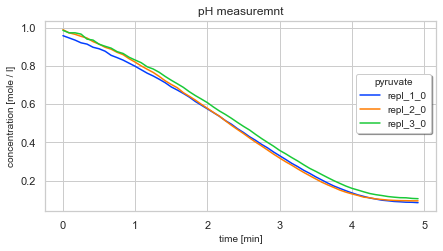

In [4]:
# Educts:
for reactant_id, stoich, _, replicates, init_conc in educts:
        
    if len(replicates) > 0:
            
        df = reaction.exportReplicates(reactant_id)
        time_val = df.index.tolist()
        time = df.index.name.split('/')[0]
        time_unit_name = df.index.name.split('/')[1]
        time_unit = enzmldoc.getUnitDict()[time_unit_name].getName()
            
        f, ax = plt.subplots(figsize=(7,3.5))
            
        # Visualization
        for col in df.columns:
                
            name = enzmldoc.getReactant(col.split('/')[1]).getName()
            unit_name = enzmldoc.getReactant(col.split('/')[1]).getSubstanceUnits()
            unit = enzmldoc.getUnitDict()[unit_name].getName()
                
            sns.lineplot( x=time_val, y=df[col], label = col.split('/')[0] )
            
        #set graph title, legend, axes 
        ax.set_title(reaction_name, fontsize = 12)

        ax.legend(fontsize = 10, \
                    bbox_to_anchor= (1, 0.75), \
                    title= name, \
                    title_fontsize = 10, \
                    shadow = True, \
                    facecolor = 'white');

        xlabel = f"{time} [{time_unit}]"
        ylabel = f"{'concentration'} [{unit}]"

        ax.set_xlabel(xlabel , fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)

Visualize products, if the EnzymeML document contains time course data for products <br>
The example data does not contain measurments of products.

In [5]:
for reactant_id, stoich, _, replicates, init_conc in products:
        
    if len(replicates) > 0:
            
        df = reaction.exportReplicates(reactant_id)
        time_val = df.index.tolist()
        time = df.index.name.split('/')[0]
        time_unit_name = df.index.name.split('/')[1]
        time_unit = enzmldoc.getUnitDict()[time_unit_name].getName()
            
        f, ax = plt.subplots(figsize=(7,3.5))
            
        # Visualization
        for col in df.columns:
                
            name = enzmldoc.getReactant(col.split('/')[1]).getName()
            unit_name = enzmldoc.getReactant(col.split('/')[1]).getSubstanceUnits()
            unit = enzmldoc.getUnitDict()[unit_name].getName()
                
            sns.lineplot( x=time_val, y=df[col], label = col.split('/')[0] )
            
        #set graph title, legend, axes 
        ax.set_title(reaction_name, fontsize = 12)

        ax.legend(fontsize = 10, \
                    bbox_to_anchor= (1, 0.75), \
                    title= name, \
                    title_fontsize = 10, \
                    shadow = True, \
                    facecolor = 'white');

        xlabel = f"{time} [{time_unit}]"
        ylabel = f"{'concentration'} [{unit}]"

        ax.set_xlabel(xlabel , fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)

## Parameter Estimation and Modeling
#### Data preparation
Convert pandas dataframe from EnzymeML data to numpy arrays. <br>
First select the reactant to model by changing the reactant_id accordingly, see overview above for selction options.<br>
In this example substrate 's0' will be modeled.

In [6]:
reactant_id = 's0'
replicates = reaction.exportReplicates(reactant_id)
# time:
data_time = replicates.index.values # numpy array shape (60,)
# substrate data (absorption):
data_s = np.transpose(replicates.iloc[:,:].to_numpy(np.float64)) # shape: (3, 60)

### Fit data to a system of ODEs
#### Define the ODE functions

In [7]:
def f(w, t, params):
    '''
    System of differential equations
    Arguments:
        w: vector of state variables: w = [v,S]
        t: time
        params: parameters
    '''
    v, s = w
    
    a = params['a'].value
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(v',s'):
    f0 = a*(vmax-v) # v'
    f1 = -v*s/(km+s) # S'
    return [f0,f1]

#### Solve ODE

In [8]:
def g(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [v0, S0])
    '''
    w = odeint(f, w0, t, args=(params,))
    return w

#### Compute residual between actual data (S) and fitted data
In this model we assume that the data contains a bias on the y-axis. <br>
Therfore we compute the distance between the modeled substrate + bias and the actual mesuared substrate

In [9]:
def residual(params, t, data_s):
    ndata, nt = data_s.shape # get dimensions of data (here we fit against 3 measurments => ndata = 3)
    resid = 0.0*data_s[:] # initialize the residual vector
    # compute residual per data set
    for i in range(ndata):
        w0 = params['v0'].value, params['S0'].value
        model = g(t, w0, params) # solve the ODE with the given parameters
        # get modeled substrate
        s_model = model[:,1]
        s_model_b = s_model + params['b'].value # adding bias
        resid[i,:]=data_s[i,:]-s_model_b # compute distance to measured data
    return resid.flatten()

#### Bringing everything together
Initialize parameters <br>
v0 is fixed on 0 <br>
For S0 the mean of first data point for all measured data is taken and substracted by the estimated bias
Initial values for all other parameters are estimated.

In [10]:
# initial conditions:
v0 = 0
s0 = np.mean(data_s,axis=0)[0]

# Set parameters including bounds
bias = np.mean(data_s,axis=0)[-1]
params = Parameters()
params.add('v0', value=v0, vary=False)
params.add('S0', value=s0-bias, min=0.1, max=s0)
params.add('a', value=1., min=0.0001, max=2.)
params.add('vmax', value=0.2, min=0.0001, max=1.)
params.add('Km', value=0.05, min=0.0001, max=1.)
params.add('b', value=bias, min=0.01, max=s0*0.5)

# time
t_measured = data_time

#### Fit model and visualize results
Statistics for the Fit and the parameters a printed. <br>
In the graph the red line shows the result of the model. <br>
The dotted curves are the measured data sets.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 180
    # variables        = 5
    chi-square         = 0.04123983
    reduced chi-square = 2.3566e-04
    Akaike info crit   = -1498.63538
    Bayesian info crit = -1482.67059
[[Variables]]
    v0:    0 (fixed)
    S0:    0.86085381 +/- 0.00534287 (0.62%) (init = 0.8834)
    a:     1.69789522 +/- 0.15512384 (9.14%) (init = 1)
    vmax:  0.28159374 +/- 0.01082388 (3.84%) (init = 0.2)
    Km:    0.04761891 +/- 0.01094690 (22.99%) (init = 0.05)
    b:     0.09725089 +/- 0.00436856 (4.49%) (init = 0.09466667)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) =  0.947
    C(a, vmax)  = -0.895
    C(a, Km)    = -0.743
    C(S0, b)    = -0.736
    C(Km, b)    = -0.638
    C(vmax, b)  = -0.504
    C(a, b)     =  0.333
    C(S0, Km)   =  0.312
    C(S0, a)    =  0.211
    C(S0, vmax) =  0.122


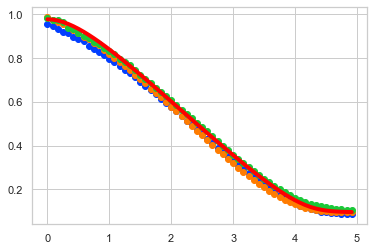

In [11]:
# fit model
result = minimize(residual , params, args=(t_measured, data_s), method='leastsq')
report_fit(result)
# plot the data sets and fits
w0 = params['v0'].value, params['S0'].value
data_fitted = g(t_measured, w0, result.params)
plt.figure()

for i in range(data_s.shape[0]):
    plt.plot(t_measured, data_s[i, :], 'o')
plt.plot(t_measured, data_fitted[:, 1]+params['b'].value, '-', linewidth=4, color='red', label='fitted data')
plt.show()

Add equeations to EnzymeML document

In [12]:
# Code

Add parameters to EnzymeML document

In [13]:
# Code

Dataverse Entry?